## Decomposition Refreshed

In [1]:
using Revise
using Random
using Printf
using StaticArrays
using DataStructures
using Flux
using FileIO
using BSON
using JLD2
using ProgressMeter
using POMDPs
using POMDPModelTools
using POMDPSimulators
using POMDPPolicies
using BeliefUpdaters
using RLInterface
using DeepQLearning
using LocalApproximationValueIteration
using DiscreteValueIteration
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using MDPModelChecking
using PedCar
using AutomotiveSensors
using Reel

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1186


loaded


┌ Info: Precompiling DeepQLearning [de0a67f4-c691-11e8-0034-5fc6e16e22d3]
└ @ Base loading.jl:1186
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DeepQLearning [de0a67f4-c691-11e8-0034-5fc6e16e22d3]
│   exception = ErrorException("Required dependency Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] failed to load from a cache file.")
└ @ Base loading.jl:963
┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/AutoViz/w0rHu.ji for AutoViz [82aa6e0c-a491-5edf-8d4b-c16b98e4ea17]
└ @ Base loading.jl:1184
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for AutoViz [82aa6e0c-a491-5edf-8d4b-c16b98e4ea17]
│   exception = ErrorException("Required dependency Cairo [159f3aea-2a34-519c-b102-8c37f9878175] failed to load from a cache file.")
└ @ Base loading.jl:963
┌ Info: Precompiling AutomotivePOMDPs [dca8afc0-c686-11e8-0934-712707da73aa]
└ @ Base loading.jl:1186
┌ Warning: Module AutoViz with bu

In [2]:
includet("../src/masking.jl")
includet("../src/util.jl")
includet("../src/masked_dqn.jl")
includet("../src/qmdp_approximation.jl")
includet("../src/decomposed_tracking.jl")
includet("../src/decomposition.jl")
includet("../src/render_helpers.jl")
includet("../RNNFiltering/RNNFiltering.jl")
using Main.RNNFiltering

In [3]:
rng = MersenneTwister(1)
cam = FitToContentCamera(0.);

## Environment

In [30]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
#                    sensor = PerfectSensor(),
                    sensor = GaussianSensor(false_positive_rate=0.0, false_negative_rate = 0.0,
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                   obs_dist = ObstacleDistribution(mdp.env, 
                                                   upper_obs_pres_prob=0., 
                                                   left_obs_pres_prob=1.0, 
                                                   right_obs_pres_prob=1.0),
                   max_cars=1, 
                   max_peds=0, 
                   car_birth=0.7, 
                   ped_birth=0., 
                   max_obstacles=1,
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);

# instantiate sub problems
## CAR POMDP FOR TRACKING 1 CAR
car_pomdp = deepcopy(pomdp)
car_pomdp.models = pomdp.models
car_pomdp.max_peds = 0
car_pomdp.max_cars = 1
## PED POMDP FOR TRACKING 1 PEDESTRIAN
ped_pomdp = deepcopy(pomdp)
ped_pomdp.models = pomdp.models
ped_pomdp.max_peds = 1
ped_pomdp.max_cars = 0
## PEDCAR POMDP FOR THE POLICY (Model checking + DQN)
pedcar_pomdp = deepcopy(pomdp)
pedcar_pomdp.models = pomdp.models # shallow copy!
pedcar_pomdp.max_peds = 1
pedcar_pomdp.max_cars = 1
pedcar_pomdp.max_obstacles = 0

0

## Load RNN Belief Updater and Policy

In [31]:
n_models = 5
car_models = Vector{Chain}(undef, n_models)
ped_models = Vector{Chain}(undef, n_models)
for i=1:n_models
    car_models[i] = BSON.load("../RNNFiltering/model_car_$i.bson")[:model] 
    Flux.loadparams!(car_models[i], BSON.load("../RNNFiltering/weights_car_$i.bson")[:weights])
    ped_models[i] = BSON.load("../RNNFiltering/model_ped_$i.bson")[:model]
    Flux.loadparams!(ped_models[i], BSON.load("../RNNFiltering/weights_ped_$i.bson")[:weights])
end
pres_threshold = 0.3;

In [32]:
threshold = 0.99
@load "../training_scripts/pc_util_processed_low.jld2" qmat util pol
safe_policy = ValueIterationPolicy(mdp, qmat, util, pol);
mask = SafetyMask(mdp, safe_policy, threshold);

In [33]:
qnetwork = BSON.load("../training_scripts/drqn-log/log20/model.bson")[:qnetwork]
weights = BSON.load("../training_scripts/drqn-log/log20/qnetwork.bson")[:qnetwork]
Flux.loadparams!(qnetwork, weights)
dqn_policy = NNPolicy(pedcar_pomdp, qnetwork, actions(pedcar_pomdp), 1)
masked_policy = MaskedNNPolicy(pedcar_pomdp, dqn_policy, mask);

In [34]:
dec_pol = DecMaskedPolicy(masked_policy, mask, pedcar_pomdp, (x,y) -> min.(x,y));

## Evaluation

In [20]:
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, dec_pol, up, n_ep=100, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:02

219.426279 seconds (391.18 M allocations: 113.198 GiB, 15.80% gc time)
Summary for 

Progress: 100%|█████████████████████████████████████████| Time: 0:03:39


100 episodes: 
Average reward: 0.035 +/- 0.008 
Average # of steps: 67.170 +/- 6.118 
Average # of violations: 0.000 +/- 0.000 


## Simulation

In [35]:
function POMDPModelTools.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
    sp, o, r = generate_sor(pomdp, s, a, rng)
    return sp, o, r, deepcopy(pomdp.models)
end

function POMDPModelTools.action_info(policy::DecMaskedPolicy, b::MultipleAgentsBelief)
    global pomdp
    pedcar_beliefs = create_pedcar_beliefs(pomdp, b) #XXX is using global variable pomdp
    a, ai = action_info(policy, pedcar_beliefs)
    safe_acts, probs, probs_dict, safe_acts_dict = ai
#     println("pedcar beliefs: ", keys(pedcar_beliefs))
    return a, (safe_acts, probs, probs_dict, safe_acts_dict, pedcar_beliefs, deepcopy(pomdp.models))
end

In [40]:
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());

s0 = initialstate(pomdp, rng)
a0 = UrbanAction(0.)
empty_b = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}(), pomdp)
o0 = generate_o(pomdp,s0, a0, s0, rng)
b0 = update(up, empty_b, a0, o0)
hr = HistoryRecorder(max_steps=400, rng=rng)
@time hist = simulate(hr, pomdp, dec_pol, up, b0, s0);

  2.472577 seconds (3.82 M allocations: 1.119 GiB, 12.95% gc time)


In [41]:
animate_history(hist, pomdp,
#                 obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
#                 belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                action_overlays = a -> [TextOverlay(text = ["Acc: $(a.acc) m/s^2"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 8.), incameraframe=true)],
                ainfo_overlays = ai -> [MultipleInterpolatedBeliefsOverlay(ai[5], pomdp, mdp, pedcar_pomdp, ai[end]),
                                        TextOverlay(text = ["Probabilities: $([round(p, digits=4) for p in ai[2]])"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 12.), incameraframe=true),
                                        TextOverlay(text = ["Available Actions: $([a.acc for a in ai[1]])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true)],
#                     [ TextOverlay(text = ["$vehid: $([round(p, digits=4) for p in probs])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,-15-1.5*i), incameraframe=true) for (i,(vehid, probs)) in enumerate(ai[3])]...],                      
#                     [ TextOverlay(text = ["$vehid: $([a.acc for a in acts])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,-15-1.5*i), incameraframe=true) for (i,(vehid, acts)) in enumerate(ai[4])]...],
#                                             
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 12.0),
                speed_factor=2)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpSOdC5d", 0x0000000000000044, 20.0, nothing)

## Error analysis

In [28]:
@showprogress for ep=1:1000
    global hist
    ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                        AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
    up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}());

    s0 = initialstate(pomdp, rng)
    a0 = UrbanAction(0.)
    empty_b = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}(), pomdp)
    o0 = generate_o(pomdp,s0, a0, s0, rng)
    b0 = update(up, empty_b, a0, o0)
    hr = HistoryRecorder(max_steps=400, rng=rng)
    hist = simulate(hr, pomdp, dec_pol, up, b0, s0);
    if sum(hist.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 1:00:15


In [25]:
animate_history(hist, pomdp,
#                 obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
#                 belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                action_overlays = a -> [TextOverlay(text = ["Acc: $(a.acc) m/s^2"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 8.), incameraframe=true)],
                ainfo_overlays = ai -> [MultipleInterpolatedBeliefsOverlay(ai[5], pomdp, mdp, pedcar_pomdp, ai[end]),
                                        TextOverlay(text = ["Probabilities: $([round(p, digits=4) for p in ai[2]])"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3., 12.), incameraframe=true),
                                        TextOverlay(text = ["Available Actions: $([a.acc for a in ai[1]])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,10.), incameraframe=true)],
#                     [ TextOverlay(text = ["$vehid: $([round(p, digits=4) for p in probs])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,-15-1.5*i), incameraframe=true) for (i,(vehid, probs)) in enumerate(ai[3])]...],                      
#                     [ TextOverlay(text = ["$vehid: $([a.acc for a in acts])"], font_size=20,pos=VecE2(pomdp.env.params.x_min + 3.,-15-1.5*i), incameraframe=true) for (i,(vehid, acts)) in enumerate(ai[4])]...],
#                                             
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 12.0),
                speed_factor=2)

Frames{MIME{Symbol("image/png")}}("/tmp/tmphN84uw", 0x0000000000000020, 20.0, nothing)

In [178]:
s = hist.state_hist[13]
pomdp.sensor = PerfectSensor()
continuous_safe_policy = SafePOMDPPolicy(mask, pomdp)
o = generate_o(pomdp, s, rng)
a, ai = action_info(continuous_safe_policy, o)
sa, probs, route = ai
println("Probas ", probs)

Probas [0.840182, 0.770308, 0.680582, 0.515436]


In [168]:
s[findfirst(101, s)]

Vehicle(101, VehicleState(VecSE2({5.993, 6.910}, 4.712), Frenet(RoadIndex({1, 0.993538}, {17, 1}), 13.910, 0.007, 3.142), 0.000), VehicleDef(PEDESTRIAN, 1.000, 1.000))

In [208]:
compute_probas(pomdp, mask, s, 101, 2)

route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]


4-element Array{Float64,1}:
 0.840181895277895 
 0.7703075855359827
 0.6805823879332716
 0.5154355810231509

In [214]:
pedcar_pomdp.models = pomdp.models

Dict{Int64,DriverModel} with 3 entries:
  2   => UrbanDriver…
  101 => IntelligentPedestrian…
  1   => EgoDriver{UrbanAction}(UrbanAction(2.0))

In [215]:
b = hist.belief_hist[13]
pcb = hist.ainfo_hist[12][end - 1]
pcbb = pcb[(2,101,1)]
compute_probas(pedcar_pomdp, mask, pcb[(2, 101, 1)])

route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
[0.867866, 0.816329, 0.749874, 0.593073]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
[0.877172, 0.826086, 0.759621, 0.6015]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
[0.843795, 0.79134, 0.725262, 0.572974]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
[0.898726, 0.851898, 0.790143, 0.641437]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]
[0.999999, 1.0, 1.0, 1.0]
route s_mdp : LaneTag[LaneTag(3, 1), LaneTag(4, 1)]


4-element Array{Float64,1}:
 0.897511538480356 
 0.857130644171401 
 0.8049801112524986
 0.6817966809237221

In [189]:
for pred in pcb[(2,101,1)].predictions
    obs = obs_to_scene(pedcar_pomdp, pred)
    probs = compute_probas(pedcar_pomdp, mask, obs, PED_ID, CAR_ID)
    println(probs)
end

[0.999998, 0.999999, 1.0, 1.0]
[0.999994, 0.999997, 1.0, 1.0]
[0.998961, 0.999185, 0.99947, 0.999646]
[0.999734, 0.999791, 0.999862, 0.999901]
[0.999998, 0.999999, 1.0, 1.0]


In [193]:
ss = obs_to_scene(pedcar_pomdp, pcbb.predictions[1]);

In [212]:
ssmdp = get_mdp_state(mdp, pomdp, ss, PED_ID, CAR_ID)
ssmdp.route

2-element SArray{Tuple{2},LaneTag,1,2}:
 LaneTag(3, 1)
 LaneTag(4, 1)

In [213]:
smdp = get_mdp_state(mdp, pomdp, s, PED_ID, CAR_ID)
smdp.route

2-element SArray{Tuple{2},LaneTag,1,2}:
 LaneTag(3, 1)
 LaneTag(4, 1)

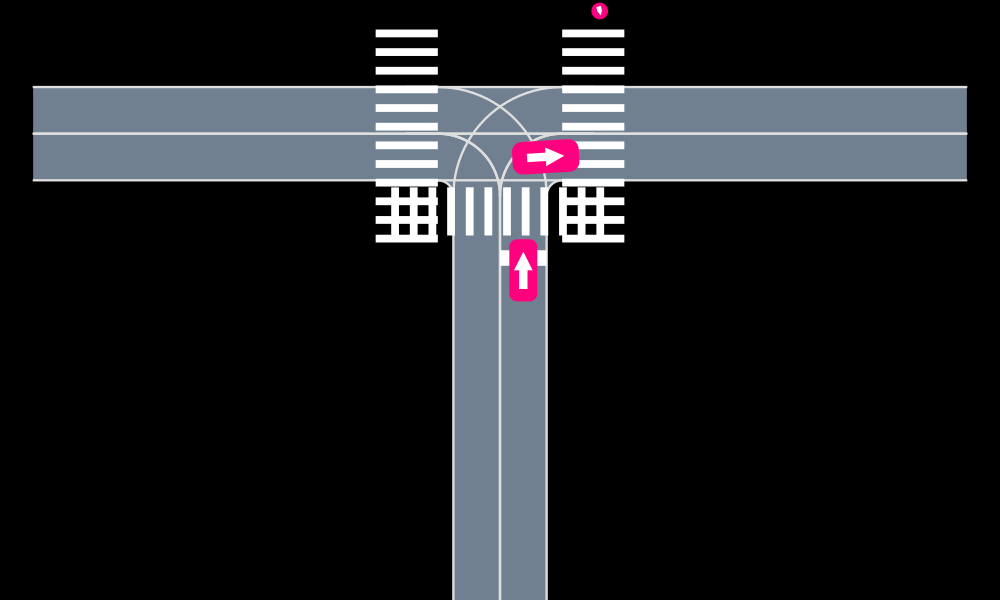

In [191]:
AutoViz.render(, pomdp.env, cam=cam)

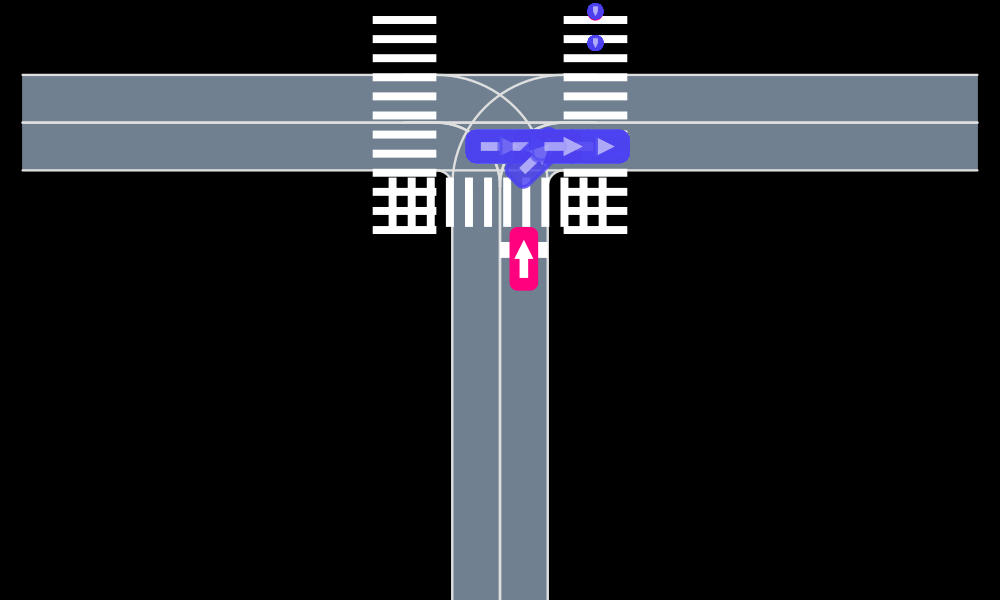

In [184]:
pc_overlay =  PedCarBeliefOverlay(pedcar_pomdp, pcb[(2, 101, 1)], MONOKAI["color4"])
itp_overlay = InterpolationOverlay(mdp, pomdp.models, s)
mitp_overlay = MultipleInterpolatedBeliefsOverlay(pcb, pomdp, mdp, pedcar_pomdp, pomdp.models)
AutoViz.render(s, pomdp.env, [mitp_overlay], cam=cam)

In [162]:
length(pcb[(2,101,1)].predictions[1])

12

In [38]:
s = hist.state_hist[end - 4]
b = hist.ainfo_hist[end - 4][5]
bb = b[(2, 101,1)]

PedCarRNNBelief(Array{Float64,1}[[0.0625, -0.215417, 1.0, 0.42, 0.000711217, 0.212845, -0.747486, 0.136436, -0.24282, 0.0276548, 1.00719, 0.095687], [0.0625, -0.215417, 1.0, 0.42, 0.0162518, 0.249588, -0.801901, 0.187845, -0.213451, -0.00989273, 0.973789, 0.103079], [0.0625, -0.215417, 1.0, 0.42, -0.0240651, 0.265608, -0.775372, 0.237054, -0.247915, -0.0196442, 0.975006, 0.114043], [0.0625, -0.215417, 1.0, 0.42, -0.0855629, 0.180073, -0.739143, 0.212066, -0.233062, 0.0114188, 1.02149, 0.106071], [0.0625, -0.215417, 1.0, 0.42, 0.0328453, 0.212662, -0.787419, 0.204028, -0.230685, 0.00203596, 0.998399, 0.0939353]], [0.0625, -0.215417, 1.0, 0.42, -0.105921, 0.251321, -0.762425, 0.238351, -0.219886, 0.015018, 1.0, 0.222582, 0.78125, 0.1875, -0.791667, -0.00333333])

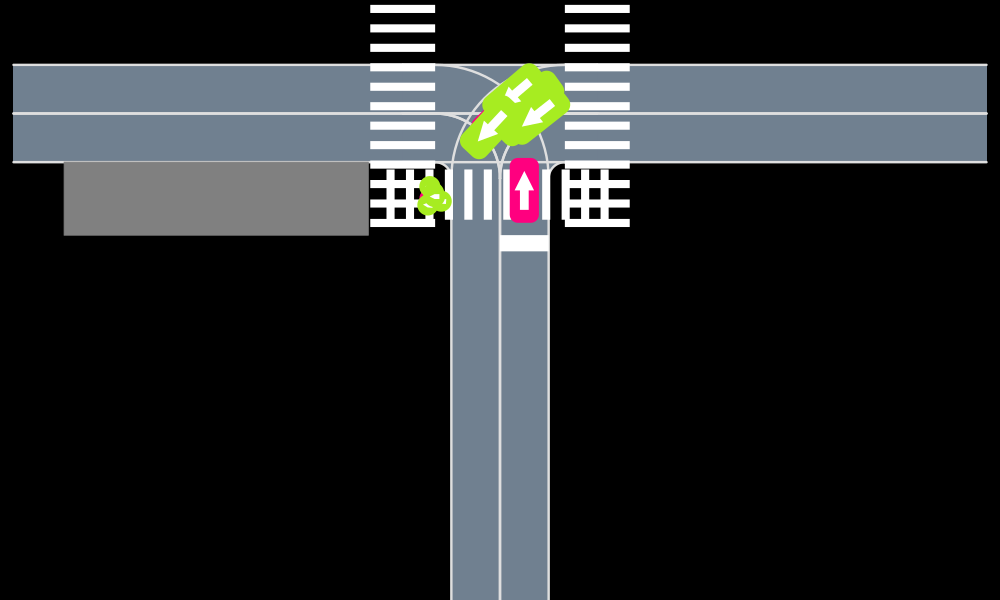

In [39]:
bel_overlay = PedCarBeliefOverlay(pedcar_pomdp, bb, MONOKAI["color2"])
AutoViz.render(s, pomdp.env, [bel_overlay], cam=FitToContentCamera(0.0))

In [35]:
safe_actions(pedcar_pomdp, mask, bb, 2, 101)

2-element Array{UrbanAction,1}:
 UrbanAction(-4.0)
 UrbanAction(-2.0)